In [5]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [6]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [7]:
k = 10 # Top 10% highest l2-magnitude filters

In [8]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)

e_beta = []
beta = []
min_beta = []
max_beta = []
for l_num, l in enumerate(conv_layers):
    print(f" ============ LAYER {l_num} ==================")
    top10F=topKfilters(model, l_num, k=k)
    beta_f = []
    for f in top10F:
        top10C = topKchannels(model, l_num, f, k=k)

        filters = tf.expand_dims(get_filter(model, l_num)[:,:,top10C, f], -1)
        s, a = getSymAntiSymTF(filters)
        a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
        s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
        total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
        #beta = a_energy/total_energy
        beta_f.append(tf.reduce_mean(a_energy/total_energy))
    beta.append(beta_f)
    print(beta)
    e_beta.append(np.mean(beta[-1]))
    '''min_beta.append(e_beta[-1] - np.min(beta))
    max_beta.append(np.max(beta)-e_beta[-1])'''






 ============ LAYER 0 ==================
[[<tf.Tensor: shape=(), dtype=float32, numpy=0.67017895>, <tf.Tensor: shape=(), dtype=float32, numpy=0.82987887>, <tf.Tensor: shape=(), dtype=float32, numpy=0.08311135>, <tf.Tensor: shape=(), dtype=float32, numpy=0.07394787>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8119719>, <tf.Tensor: shape=(), dtype=float32, numpy=0.99005777>]]
 ============ LAYER 1 ==================
[[<tf.Tensor: shape=(), dtype=float32, numpy=0.67017895>, <tf.Tensor: shape=(), dtype=float32, numpy=0.82987887>, <tf.Tensor: shape=(), dtype=float32, numpy=0.08311135>, <tf.Tensor: shape=(), dtype=float32, numpy=0.07394787>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8119719>, <tf.Tensor: shape=(), dtype=float32, numpy=0.99005777>], [<tf.Tensor: shape=(), dtype=float32, numpy=0.52927965>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17054267>, <tf.Tensor: shape=(), dtype=float32, numpy=0.57357234>, <tf.Tensor: shape=(), dtype=float32, numpy=0.29954323>, <tf.Tensor: shape

In [9]:
e_beta

[0.57652444,
 0.42465976,
 0.539331,
 0.6437796,
 0.64858955,
 0.74609905,
 0.078381516,
 0.6448276,
 0.49665055,
 0.527002,
 0.63062733,
 0.30950746,
 0.17587167,
 0.4244068,
 0.33590183,
 0.08331244]

In [10]:
e_beta

[0.57652444,
 0.42465976,
 0.539331,
 0.6437796,
 0.64858955,
 0.74609905,
 0.078381516,
 0.6448276,
 0.49665055,
 0.527002,
 0.63062733,
 0.30950746,
 0.17587167,
 0.4244068,
 0.33590183,
 0.08331244]

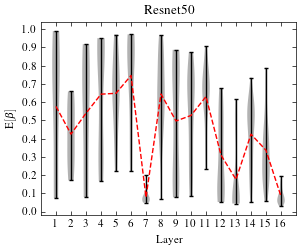

In [11]:
plt.violinplot(beta)
plt.plot(np.arange(1, len(conv_layers)+1), e_beta)
#plt.errorbar(np.arange(0, len(conv_layers)), e_beta, yerr = [min_beta, max_beta], fmt ='o')

plt.xlabel("Layer")
plt.ylabel(r"$\text{E}[\beta]$")
plt.xticks(np.arange(1, len(conv_layers)+1, step=1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Resnet50')

plt.minorticks_off()
plt.savefig('figures/resnet50_ebeta.png', dpi=600)

plt.show()
plt.close()

In [12]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           